# Tutorial 02 - Loading and Visualizing Exported Surface Data

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to generate aggregate heatmaps. We will follow these steps:

1. Load the data using `Pandas`
2. Visualize gaze data for 1 surface for 1 participant as a heatmap.
3. Visualize gaze data for 1 surface for multiple participants as a heatmap.

## 1 - Loading Exported Surface Data

Let's begin by loading exported gaze data on a surface. The file will be named with the pattern `gaze_positions_on_surface_<your-surface-name>_<uid>.csv`

In [90]:
import os
import pandas as pd

recordings_location = '/home/pupil-labs/recordings'
demo_recording = '2019_02_14/000'
file_name = 'gaze_positions_on_surface_magazine_cover_1550027153.7953088.csv'
exported_surface_csv = os.path.join(recording_location, demo_recording, 
                                    'exports', '000', 'surfaces', file_name)
surface_pd_frame = pd.read_csv(exported_gaze_on_surface_csv)

print("Columns present in exported gaze on surface data:\n {}".format(surface_pd_frame.columns))

Columns present in exported gaze on surface data:
 Index(['world_timestamp', 'world_frame_idx', 'gaze_timestamp', 'x_norm',
       'y_norm', 'x_scaled', 'y_scaled', 'on_srf', 'confidence'],
      dtype='object')


### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_timestamp` - The world camera timestamp at which the sample was recorded.
- `world_frame_idx` - The frame number of the world camera to which this sample is correlated.
- `gaze_timestamp` - The timestamp of the gaze position which is correlated with this world frame (note that there can be many gaze positions per world frame due to higher sampling rate of eye cameras relative to world cameras)
- `x_norm` - the normalized x position of the gaze relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the gaze is **not** on the surface. 
- `y_norm` - the normalized y position of the gaze relative to the surface.
- `x_scaled` and `y_scaled` - the position of the gaze relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture. 
- `on_srf` - boolean value if gaze is within the bounds of the surface
- `confidence` - confidence of the pupil detection

Let's take a look at a few values from our sample surface data!


In [91]:
gaze_on_srf = surface_pd_frame[surface_pd_frame.on_srf == True]
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("gaze on (magazine surface) data:\n {}".format(gaze_on_srf[headers][:5]))

gaze on (magazine surface) data:
      world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  \
358       175528.836               21      175528.841   0.991   0.334   
360       175528.836               21      175528.846   0.950   0.337   
362       175528.836               21      175528.851   0.866   0.368   
364       175528.836               21      175528.856   0.824   0.370   
366       175528.836               21      175528.861   0.783   0.451   

     x_scaled  y_scaled  on_srf  confidence  
358   396.451   166.800    True       1.000  
360   380.146   168.625    True       0.996  
362   346.586   183.868    True       0.392  
364   329.673   185.094    True       0.990  
366   313.334   225.556    True       0.436  


We could take this example further by filtering out low `confidence` pupil detection values:

In [92]:
gaze_on_srf = surface_pd_frame[(surface_pd_frame.on_srf == True) & (surface_pd_frame.confidence > 0.8)]
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("gaze on (magazine surface) data:\n {}".format(gaze_on_srf[headers][:5]))

gaze on (magazine surface) data:
      world_timestamp  world_frame_idx  gaze_timestamp  x_norm  y_norm  \
358       175528.836               21      175528.841   0.991   0.334   
360       175528.836               21      175528.846   0.950   0.337   
364       175528.836               21      175528.856   0.824   0.370   
449       175529.071               26      175529.083   0.988   0.549   
450       175529.071               26      175529.085   0.930   0.581   

     x_scaled  y_scaled  on_srf  confidence  
358   396.451   166.800    True       1.000  
360   380.146   168.625    True       0.996  
364   329.673   185.094    True       0.990  
449   395.045   274.474    True       0.998  
450   372.167   290.370    True       0.997  


## 2 - Visualize aggregate gaze on surface for single participant

Now we visualize high confidence gaze data on this surface.

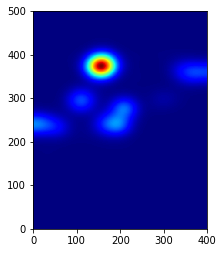

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

grid = (500,400)
heatmap_detail = 0.04
gaze_x_scaled = gaze_on_srf['x_norm']
gaze_y_scaled = gaze_on_srf['y_norm']

hist, x_edges, y_edges = np.histogram2d(
            gaze_y_scaled, gaze_x_scaled, range=[[0, 1.0], [0, 1.0]], normed=False, bins=grid)
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
hist_max = hist.max()
hist *= (255.0 / hist_max) if hist_max else 0.0

plt.imshow(gaussian_filter(hist, sigma=(filter_w, filter_h), order=0), 
           interpolation=None, shape=grid, origin='lower', cmap='jet', alpha=1)

## 3 - Visualize aggregate gaze on surface for multiple participants

We will now repeat steps 1 and 2 from above but will load the same `surface` from multiple recordings. This could be considered as an example of how to make an aggregate heatmap for multiple participants in a single study.


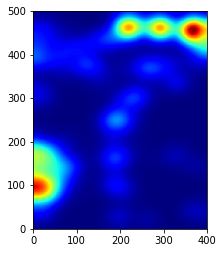

In [82]:
from glob import glob

demo_recordings_path = '2019_02_14'
surface_path_pattern = '**/exports/**/surfaces/gaze_positions_on_surface_magazine_cover_*.csv'
surface_files = glob(os.path.join(recordings_location, demo_recordings_path, surface_path_pattern), 
                     recursive=True)

surface_pd_frames = pd.DataFrame()
for fp in surface_files:
    frame = pd.read_csv(fp)
    
    surface_pd_frames = surface_pd_frames.append(frame)
    
gaze_on_surfaces = surface_pd_frames[(surface_pd_frames.on_srf == True) & (surface_pd_frames.confidence > 0.8)]    
gaze_x_scaled = gaze_on_surfaces['x_norm']
gaze_y_scaled = gaze_on_surfaces['y_norm']

hist, x_edges, y_edges = np.histogram2d(
            gaze_y_scaled, gaze_x_scaled, range=[[0, 1.0], [0, 1.0]], normed=False, bins=grid)
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
hist_max = hist.max()
hist *= (255.0 / hist_max) if hist_max else 0.0

plt.imshow(gaussian_filter(hist, sigma=(filter_w, filter_h), order=0), 
           interpolation=None, shape=grid, origin='lower', cmap='jet', alpha=1)
